In [93]:
# plot_emc2_time_series_fig10.ipynb
#
# Author: McKenna W. Stanford
# 
# Utility: Plots time-height series of E3->EMC2. Produces Fig. 10 of the manuscript.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import emc2
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import os
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from scipy.interpolate import griddata as griddata
import pandas
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from file_struct import file_struct as fs
from load_sonde_data import load_sonde_data
from give_me_files_and_subfolders import give_me_files_and_subfolders
from calculate_theta_and_more import calculate_theta_and_more
from scipy.signal import argrelextrema
import seaborn as sns
from dask.distributed import Client, progress, LocalCluster
import palettable

In [94]:
#--------------------------------------------
# Functions
#--------------------------------------------
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

def toDatetime(d):
    return datetime.datetime.utcfromtimestamp(d)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx   

# function to make serial date numbers which are the number of days that have passed
# since epoch beginning given as days.fraction_of_day
def datenum(d):
        return 366 + d.toordinal() + (d - datetime.datetime.fromordinal(d.toordinal())).total_seconds()/(24*60*60)
#--------------------------------------------

In [95]:
#--------------------------------------------
# Occurrence Frequency
#--------------------------------------------
def occur_freq(data,bins,full_length):
    tmp_hist = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data < bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)
        elif ii == (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data <= bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)            
    tmp_hist = np.array(tmp_hist)
    return tmp_hist,bins

In [96]:
# Read in EMC2 files
dirpath = '/mnt/raid/mwstanfo/emc2/micro/'
dirs = glob.glob(dirpath+'20*')
dirs = sorted(dirs)



files = []
for xdir in dirs:
    tmp_files = glob.glob(xdir+'/*.nc')
    tmp_files = sorted(tmp_files)
    files.append(tmp_files)
files = np.concatenate(files)

# Read in E3 files
dirpath = '/mnt/raid/mwstanfo/emc2/e3_run/'
dirs = glob.glob(dirpath+'20*')
dirs = sorted(dirs)



e3_files = []
for xdir in dirs:
    tmp_files = glob.glob(xdir+'/*.nc')
    tmp_files = sorted(tmp_files)
    e3_files.append(tmp_files)
e3_files = np.concatenate(e3_files)
print(len(files))
print(len(e3_files))

96
96


In [97]:
def process_file(file,e3_file):
    var_dict = {}

    ncfile = xarray.open_dataset(file)
    var_dict['time'] = ncfile.coords['time'].values
    var_dict['z'] = np.squeeze(ncfile['z'].values)
    ref = np.squeeze(ncfile['sub_col_Ze_att_tot'].values)
    var_dict['ref'] = np.transpose(ref,axes=(1,2,0))
    vel = np.squeeze(ncfile['sub_col_Vd_tot_strat'].values)
    var_dict['vel'] = np.transpose(vel,axes=(1,2,0))
    beta_att = np.squeeze(ncfile['sub_col_beta_att_tot'].values)
    var_dict['beta_att'] = np.transpose(beta_att,axes=(1,2,0))
    var_dict['level'] = ncfile['level'].values
    detect_mask = np.squeeze(ncfile['detect_mask'].values)
    var_dict['detect_mask'] = detect_mask
    strat_qcl = np.squeeze(ncfile['strat_q_subcolumns_cl'].values)
    strat_qcl = np.transpose(strat_qcl,axes=(1,2,0))
    strat_qci = np.squeeze(ncfile['strat_q_subcolumns_ci'].values)
    strat_qci = np.transpose(strat_qci,axes=(1,2,0))
    strat_qpl = np.squeeze(ncfile['strat_q_subcolumns_pl'].values)
    strat_qpl = np.transpose(strat_qpl,axes=(1,2,0))
    strat_qpi = np.squeeze(ncfile['strat_q_subcolumns_pi'].values)
    strat_qpi = np.transpose(strat_qpi,axes=(1,2,0))
    conv_qcl = np.squeeze(ncfile['conv_q_subcolumns_cl'].values)
    conv_qcl = np.transpose(conv_qcl,axes=(1,2,0))
    conv_qci = np.squeeze(ncfile['conv_q_subcolumns_ci'].values)
    conv_qci = np.transpose(conv_qci,axes=(1,2,0))
    conv_qpl = np.squeeze(ncfile['conv_q_subcolumns_pl'].values)
    conv_qpl = np.transpose(conv_qpl,axes=(1,2,0))
    conv_qpi = np.squeeze(ncfile['conv_q_subcolumns_pi'].values)
    conv_qpi = np.transpose(conv_qpi,axes=(1,2,0))
    strat_frac_subcolumns_cl = np.squeeze(ncfile['strat_frac_subcolumns_cl'].values)
    strat_frac_subcolumns_cl = np.transpose(strat_frac_subcolumns_cl,axes=(1,2,0))
    conv_frac_subcolumns_cl = np.squeeze(ncfile['conv_frac_subcolumns_cl'].values)
    conv_frac_subcolumns_cl = np.transpose(conv_frac_subcolumns_cl,axes=(1,2,0))
    ncfile.close()
    
    var_dict['conv_frac_subcolumns_cl'] = conv_frac_subcolumns_cl
    var_dict['strat_frac_subcolumns_cl'] = strat_frac_subcolumns_cl
    var_dict['strat_qcl'] = strat_qcl
    var_dict['conv_qcl'] = conv_qcl
    
    tot_qcl = strat_qcl + conv_qcl
    
    ncfile = xarray.open_dataset(e3_file)
    vm_mcci = np.array(np.squeeze(ncfile['vm_mcci'])) # Mass-Weighted Convective Cloud Ice Fall Speed m/s
    vm_mccl = np.array(np.squeeze(ncfile['vm_mccl'])) # Mass-Weighted Convective Cloud Liquid Fall Speed m/s
    vm_mcpi = np.array(np.squeeze(ncfile['vm_mcpi'])) # Mass-Weighted Convective Precipitating Ice Fall Speed m/s
    vm_mcpl = np.array(np.squeeze(ncfile['vm_mcpl'])) # Mass-Weighted Convective Precipitating Liquid Fall Speed m/s
    
    vm_ssci = np.array(np.squeeze(ncfile['vm_ssci'])) # Mass-Weighted Stratiform Cloud Ice Fall Speed m/s
    vm_sscl = np.array(np.squeeze(ncfile['vm_sscl'])) # Mass-Weighted Stratiform Cloud Water Fall Speed m/s
    vm_sspi = np.array(np.squeeze(ncfile['vm_sspi'])) # Mass-Weighted Stratiform Snow Fall Speed m/s
    vm_sspl = np.array(np.squeeze(ncfile['vm_sspl'])) # Mass-Weighted Stratiform Rain Fall Speed m/s

    ncfile.close()
    
    # state variables
    # pressure
    pres = np.array(np.squeeze(ncfile['p_3d'])) # mb/hPa
    # convert to Pa
    pres = pres*100
    
    # temperature
    temp = np.array(np.squeeze(ncfile['t'])) # K
    # specific humidity
    q = np.array(np.squeeze(ncfile['q'])) # kg/kg
    # rh
    rhw = np.array(np.squeeze(ncfile['rhw'])) # %

    # calculate virtual temperature
    epsilon = 0.622
    tv = temp * ( (q + epsilon) / (epsilon*(1 + q)) ) 
    
    # compute air density
    R=287. #J/K/kg
    rho = pres/(tv*R)

    # calculate precipitation rates by multiplying
    # the condensed water content by the fall velocity
    dum_arr = np.zeros(np.shape(conv_qci))
    conv_pi_pr = dum_arr.copy()
    conv_pl_pr = dum_arr.copy()
    strat_pi_pr = dum_arr.copy()
    strat_pl_pr = dum_arr.copy()
    
    tot_clwc = dum_arr.copy()
    strat_clwc = dum_arr.copy()
    conv_clwc = dum_arr.copy()
    
    for dumi in range(8):
        conv_clwc[:,:,dumi] = conv_qcl[:,:,dumi]*rho
        strat_clwc[:,:,dumi] = strat_qcl[:,:,dumi]*rho
        
        conv_pi_pr[:,:,dumi] = conv_qpi[:,:,dumi]*rho*vm_mcpi*3600
        conv_pl_pr[:,:,dumi] = conv_qpl[:,:,dumi]*rho*vm_mcpl*3600

        strat_pi_pr[:,:,dumi] = strat_qpi[:,:,dumi]*vm_sspi*3600
        strat_pl_pr[:,:,dumi] = strat_qpl[:,:,dumi]*vm_sspl*3600
        
        tot_clwc[:,:,dumi] = tot_qcl[:,:,dumi]*rho
    
    conv_pr = (conv_pi_pr + conv_pl_pr)
    strat_pr = (strat_pi_pr + strat_pl_pr)
    tot_pr = conv_pr + strat_pr

    precip_rates = {'conv_pi_pr':conv_pi_pr,\
                   'conv_pl_pr':conv_pl_pr,\
                   'strat_pi_pr':strat_pi_pr,\
                   'strat_pl_pr':strat_pl_pr,\
                   'conv_pr':conv_pr,\
                   'strat_pr':strat_pr,\
                   'tot_pr':tot_pr,\
                   'conv_clwc':conv_clwc,\
                   'strat_clwc':strat_clwc,\
                   'rho':rho,\
                   'temp':temp,\
                   'rhw':rhw,\
                    'tot_qcl':tot_qcl,\
                    'tot_clwc':tot_clwc,\
                   }
        
    for key,val in precip_rates.items():
        var_dict[key] = val        
    

    return var_dict    

In [98]:
def calc_cbh(conv_frac_subcolumns_cl,strat_frac_subcolumns_cl,time,height):
    #---------------------------        
    # calculate CBHs
    #---------------------------     
    num_subs = 8
    cbh_subs = np.zeros((len(time),num_subs))
    cbh_subs_id = np.zeros((len(time),num_subs))
        
    for tt in range(len(time)):
        
        cbh = np.zeros(len(time))
        cbh_id = np.zeros(len(time))
        
        for ii in range(num_subs):
            single_time_conv_frac_subcolumns_cl = conv_frac_subcolumns_cl[tt,:,ii]
            single_time_strat_frac_subcolumns_cl = strat_frac_subcolumns_cl[tt,:,ii]
            
            single_time_z = height[tt,:]
            
            dum_cloud_mask = np.zeros(len(single_time_conv_frac_subcolumns_cl))
            tmpid = np.where(single_time_conv_frac_subcolumns_cl == True)
            if np.size(tmpid) > 0.:
                dum_cloud_mask[tmpid] = 1
            tmpid = np.where(single_time_strat_frac_subcolumns_cl == True)
            if np.size(tmpid) > 0.:
                dum_cloud_mask[tmpid] = 1
            liq_cloud_id = np.where(dum_cloud_mask == 1.)
            if np.size(liq_cloud_id) > 0.:
                liq_cloud_id = liq_cloud_id[0]
                cbh[tt] = single_time_z[liq_cloud_id[0]]
                cbh_id[tt] = liq_cloud_id[0]
            else:
                cbh[tt] = np.nan
                cbh_id[tt] = np.nan
                
            cbh_subs[tt,ii] = cbh[tt]
            cbh_subs_id[tt,ii] = cbh_id[tt]
            
    return cbh_subs,cbh_subs_id

In [99]:
num_files = len(files)
print(num_files)

96


In [100]:
for ii in range(num_files):
    outdict = process_file(files[ii],e3_files[ii])
    # Calculate CBH
    #cbh,cbh_ids = calc_cbh(outdict['conv_frac_subcolumns_cl'],outdict['strat_frac_subcolumns_cl'],outdict['time'],outdict['z'])
    #outdict['cbh'] = cbh
    print(a)

NameError: name 'a' is not defined

In [101]:
days = []
for time in outdict['time']:
    x = time
    x = pd.to_datetime(x)
    days.append(x.day)
unique_days = np.unique(days)

In [13]:
def plot_figure_a(ref,beta_att,time,height,level,detect_mask,temp,tot_pr,cbh):

    plot_cbh_arg = True
    
    fig = plt.figure(figsize=(18,10))
    dfmt = mdates.DateFormatter('%H:%M')

    ymax=3

    ax1_ref = fig.add_subplot(4,3,1)
    ax2_ref = fig.add_subplot(4,3,4)
    ax3_ref = fig.add_subplot(4,3,7)
    ax4_ref = fig.add_subplot(4,3,10)
    #ax5_ref = fig.add_subplot(8,3,13)
    #ax6_ref = fig.add_subplot(8,3,16)
    #ax7_ref = fig.add_subplot(8,3,19)
    #ax8_ref = fig.add_subplot(8,3,22)


    ax1_beta_att = fig.add_subplot(4,3,2)
    ax2_beta_att = fig.add_subplot(4,3,5)
    ax3_beta_att = fig.add_subplot(4,3,8)
    ax4_beta_att = fig.add_subplot(4,3,11)
    #ax5_beta_att = fig.add_subplot(8,3,14)
    #ax6_beta_att = fig.add_subplot(8,3,17)
    #ax7_beta_att = fig.add_subplot(8,3,20)
    #ax8_beta_att = fig.add_subplot(8,3,23)
    
    ax1_pr = fig.add_subplot(4,3,3)
    ax2_pr = fig.add_subplot(4,3,6)
    ax3_pr = fig.add_subplot(4,3,9)
    ax4_pr = fig.add_subplot(4,3,12)
    #ax5_pr = fig.add_subplot(8,3,15)
    #ax6_pr = fig.add_subplot(8,3,18)
    #ax7_pr = fig.add_subplot(8,3,21)
    #ax8_pr = fig.add_subplot(8,3,24)

    ax_ref_list = [ax1_ref,ax2_ref,ax3_ref,ax4_ref]
    #ax_ref_list = [ax1_ref,ax2_ref,ax3_ref,ax4_ref,ax5_ref,ax6_ref,ax7_ref,ax8_ref]
    ax_beta_att_list = [ax1_beta_att,ax2_beta_att,ax3_beta_att,ax4_beta_att]
    #ax_beta_att_list = [ax1_beta_att,ax2_beta_att,ax3_beta_att,ax4_beta_att,ax5_beta_att,ax6_beta_att,ax7_beta_att,ax8_beta_att]
    ax_pr_list = [ax1_pr,ax2_pr,ax3_pr,ax4_pr]
    #ax_pr_list = [ax1_pr,ax2_pr,ax3_pr,ax4_pr,ax5_pr,ax6_pr,ax7_pr,ax8_pr]
    Fontsize=10

    axlist = np.concatenate([ax_ref_list,ax_beta_att_list,ax_pr_list])

    for ax in axlist:
        ax.grid(which='both',ls='dotted',lw=1,c='grey')
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        
        dum_date = pd.to_datetime(time[0])
        dum_year = dum_date.year
        dum_month = dum_date.month
        dum_day = dum_date.day
        dum_hours = [0,6,12,18]
        dum_times = []
        for ii in range(4):
            dum_hour = dum_hours[ii]
            dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
        dum_times.append(dum_times[0]+datetime.timedelta(days=1))
        ax.set_xticks(dum_times)
        ax.set_ylim(0,ymax)
    
    ax1_ref.set_title('Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_beta_att.set_title('$\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_pr.set_title('Precip. Rate',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')



    
    #---------------------------------
    # Reflectivity Plots
    #---------------------------------
    for ii in range(len(ax_ref_list)):
        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        ax = ax_ref_list[ii]
        cmap = matplotlib.cm.get_cmap("nipy_spectral").copy()
        cmap.set_bad('white')
        tmp_ref = ref[:,:,ii]
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_ref,\
                                vmin=-50.,vmax=20.,\
                                cmap=cmap)
        # colorbar
        ref_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        ref_cbar.ax.tick_params(labelsize=Fontsize)
        ref_cbar.ax.set_ylabel('95 GHz Attenuated\n$Z_{e}$ [dBZ]',fontsize=Fontsize)   

        # hatch values below Ze_min
        var_array = tmp_ref
        mask_array = detect_mask[:,:,ii]
        hatch = '\\/...'
        ax.pcolor(x,\
                   y*1.e-3,\
                   np.ma.masked_where(mask_array == 0,np.ones_like(var_array)),\
                   hatch=hatch,\
                   alpha=0.)        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')

        # Plot CBH
        if plot_cbh_arg:
            tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
            
    #---------------------------------
    # Attenuated Backscatter Plots
    #---------------------------------
    for ii in range(len(ax_beta_att_list)):
        ax = ax_beta_att_list[ii]
        tmp_beta_att = beta_att[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        cmap = matplotlib.cm.get_cmap("viridis").copy()
        cmap.set_under
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_beta_att,\
                                cmap=cmap,\
                                norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
        # colorbar
        beta_att_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        beta_att_cbar.ax.tick_params(labelsize=Fontsize)
        beta_att_cbar.ax.set_ylabel('910 nm $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        if plot_cbh_arg:
            tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')

    #---------------------------------
    # Precip. Rate Plots
    #---------------------------------
    for ii in range(len(ax_pr_list)):
        ax = ax_pr_list[ii]
        tmp_pr = tot_pr[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask

        cmap = matplotlib.cm.get_cmap("twilight").copy()
        cmap.set_under

        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_pr,\
                                cmap=cmap,\
                                norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
        # colorbar
        pr_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        pr_cbar.ax.tick_params(labelsize=Fontsize)
        pr_cbar.ax.set_ylabel('Precip. Rate [mm hr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        if plot_cbh_arg:
            tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')  
        
        
    dumstr = dum_date.strftime('%m/%d/%Y')
    plt.suptitle(dumstr,fontsize=Fontsize*2.)

    
    legend_elements = [Line2D([0], [0], label='0$^{\\circ}$C',lw=2,color='maroon',ls='dashed'),\
                      Line2D([0], [0], label='CBH',marker='o',c='white',markerfacecolor='magenta',markeredgecolor='magenta',markeredgewidth=0,markersize=5,alpha=1)]
    lgnd = ax1_beta_att.legend(handles=legend_elements,fontsize=Fontsize*1.5,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.35),ncol=2)
    
    ax2_ref.text(-0.25,0,'Subcolumns',transform=ax2_ref.transAxes,fontweight='bold',fontsize=Fontsize*2,color='dimgrey',ha='center',va='center',rotation=90)
    
    plt.subplots_adjust(top=0.9,hspace=0.3)
        
        
        
    plt.show()
    plt.close()

In [14]:
def plot_figure_b(max_ref,max_beta_att,max_tot_pr,temp,time,height,level,cbh):
    Fontsize=10
    fig = plt.figure(figsize=(18,4))
    dfmt = mdates.DateFormatter('%H:%M')
    ymax=3
    plot_cbh_arg = True

    ax_max_ref = fig.add_subplot(131)
    ax_max_beta_att = fig.add_subplot(132)
    ax_max_tot_pr = fig.add_subplot(133)
    
    axlist = [ax_max_ref,ax_max_beta_att,ax_max_tot_pr]
    
    for ax in axlist:
        ax.grid(which='both',ls='dotted',lw=1,c='grey')
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        
        dum_date = pd.to_datetime(time[0])
        dum_year = dum_date.year
        dum_month = dum_date.month
        dum_day = dum_date.day
        dum_hours = [0,6,12,18]
        dum_times = []
        for ii in range(4):
            dum_hour = dum_hours[ii]
            dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
        dum_times.append(dum_times[0]+datetime.timedelta(days=1))
        ax.set_xticks(dum_times)
        ax.set_ylim(0,ymax)
        
    ax_max_ref.set_title('Subcolumn Max Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_beta_att.set_title('Subcolumn Max $\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_tot_pr.set_title('Subcolumn Max PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    
    
    time_2d = []
    for kk in range(len(height)):
        time_2d.append(time)
    time_2d = np.array(time_2d)
    p = level
    x = time
    y = height
    x,p = np.meshgrid(x,p)
    x = x.T
    mask_array = detect_mask     
    
    #---------------------------------
    # Max Reflectivity Plot
    #---------------------------------
    cmap = plt.cm.nipy_spectral
    tmp_plot = ax_max_ref.pcolormesh(x,\
                            y*1.e-3,\
                            max_ref,\
                            vmin=-50.,vmax=20.,\
                            cmap=cmap)
    # colorbar
    ref_cbar = plt.colorbar(tmp_plot,ax=ax_max_ref,orientation='vertical')
    ref_cbar.ax.tick_params(labelsize=Fontsize)
    ref_cbar.ax.set_ylabel('Subcol. Max Reflectivity [dBZ]',fontsize=Fontsize)     
    # Plot CBH
    if plot_cbh_arg:
        for ii in range(0,8):
            tmp_plot = ax_max_ref.scatter(time,cbh[:,ii]*1.e-3,s=15,c='magenta',label='CBH',alpha=0.5)    
    #---------------------------------
    # Max Beta Att Plot
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_beta_att.pcolormesh(x,\
                            y*1.e-3,\
                            max_beta_att,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
    # colorbar
    beta_att_cbar = plt.colorbar(tmp_plot,ax=ax_max_beta_att,orientation='vertical')
    beta_att_cbar.ax.tick_params(labelsize=Fontsize)
    beta_att_cbar.ax.set_ylabel('Subcol. Max $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)      
    # Plot CBH
    if plot_cbh_arg:
        for ii in range(0,8):
            tmp_plot = ax_max_beta_att.scatter(time,cbh[:,ii]*1.e-3,s=15,c='magenta',label='CBH',alpha=0.5)   
        
    #---------------------------------
    # Subcolumn Max Total Precipitation Rate
    #---------------------------------
    cmap = plt.cm.twilight
    tmp_plot = ax_max_tot_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_tot_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    tot_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_tot_pr,orientation='vertical')
    tot_pr_cbar.ax.tick_params(labelsize=Fontsize)
    tot_pr_cbar.ax.set_ylabel('Subcol. Max PR [mm hr$^{-1}$]',fontsize=Fontsize)     

    # Plot CBH
    if plot_cbh_arg:
        for ii in range(0,8):
            tmp_plot = ax_max_tot_pr.scatter(time,cbh[:,ii]*1.e-3,s=15,c='magenta',label='CBH',alpha=0.5)     

    
    ax_max_tot_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_beta_att.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_ref.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    


    legend_elements = [Line2D([0], [0], label='0$^{\\circ}$C',lw=2,color='maroon',ls='dashed'),\
                      Line2D([0], [0], label='CBH',marker='o',c='white',markerfacecolor='magenta',markeredgecolor='magenta',markeredgewidth=0,markersize=5,alpha=1)]
    lgnd = ax_max_tot_pr.legend(handles=legend_elements,fontsize=Fontsize*1.5,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.25),ncol=2)    
    
    
    dumstr = dum_date.strftime('%m/%d/%Y')
    plt.suptitle(dumstr,fontsize=Fontsize*2.)
    
    plt.subplots_adjust(top=0.8)
        
        
        
    plt.show()
    plt.close()

/tmp/ipykernel_33087/876145224.py:94: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  tmp_plot = ax.pcolormesh(x,\
/tmp/ipykernel_33087/876145224.py:94: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  tmp_plot = ax.pcolormesh(x,\
/tmp/ipykernel_33087/876145224.py:108: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(x,\
/tmp/ipykernel_33087/876145224.py:139: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not 

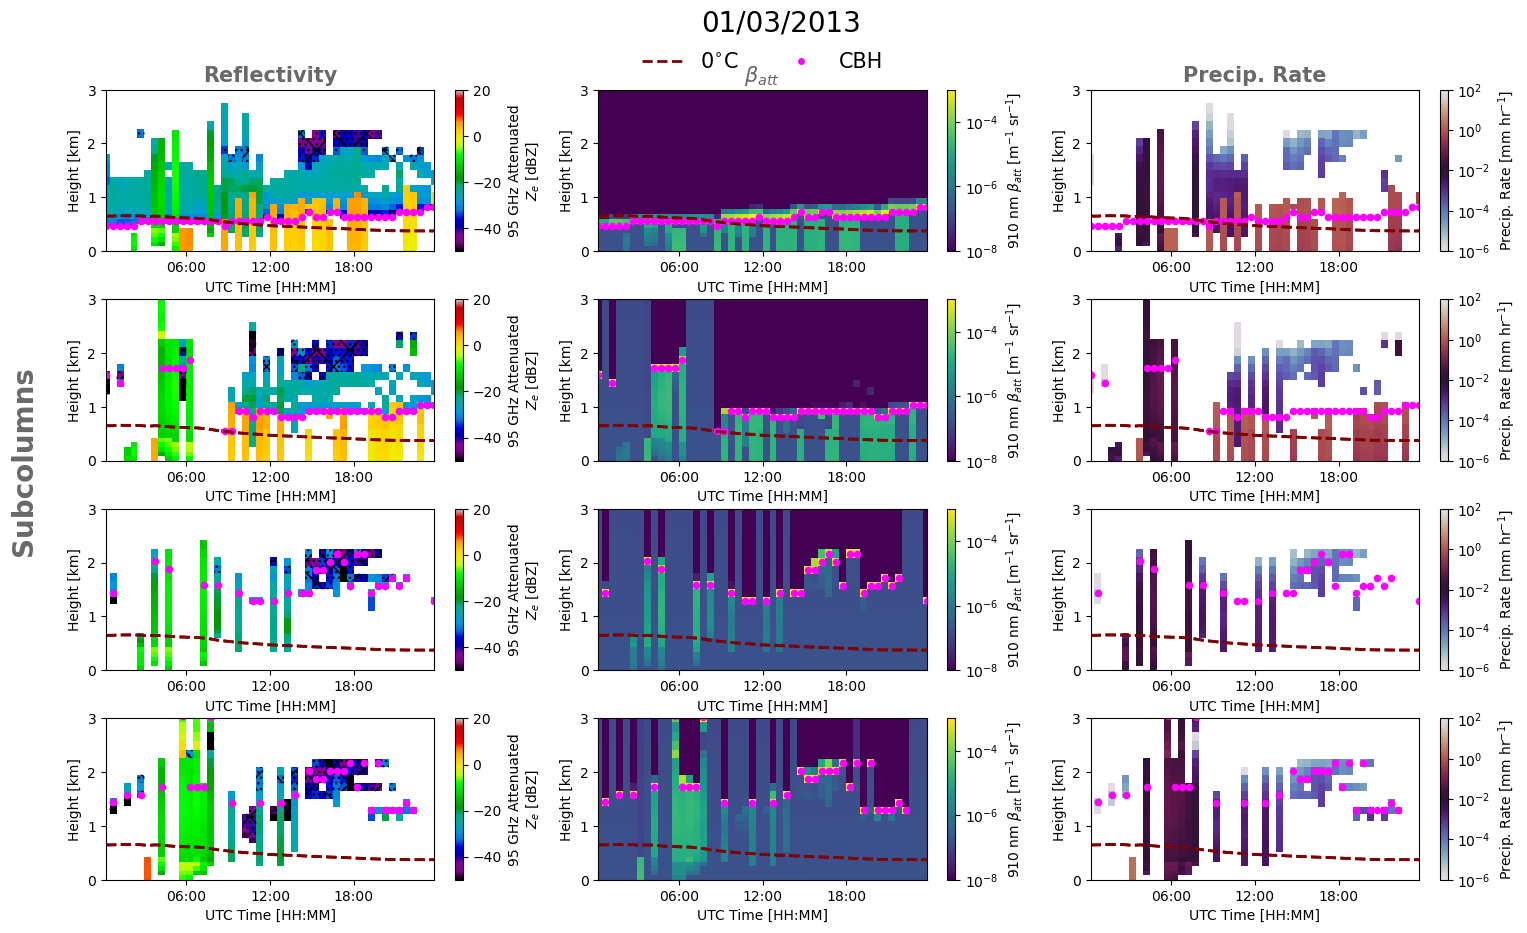

/tmp/ipykernel_33087/3390919504.py:28: RuntimeWarning: All-NaN slice encountered
  max_ref = np.nanmax(ref,axis=2)
/tmp/ipykernel_33087/1537177822.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  tmp_plot = ax_max_ref.pcolormesh(x,\
/tmp/ipykernel_33087/1537177822.py:55: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  tmp_plot = ax_max_ref.pcolormesh(x,\
/tmp/ipykernel_33087/1537177822.py:72: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  tmp_pl

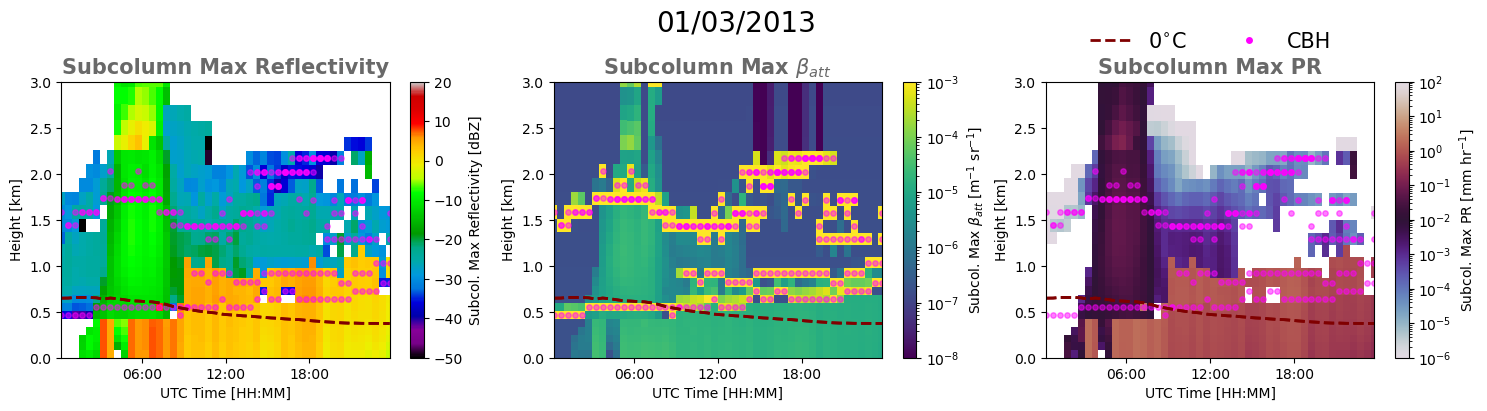

done


In [15]:
#--------------------------------------------------
# Plot figures for talks
#--------------------------------------------------
for day in unique_days[2:3]:
    time = outdict['time']
    dumid = np.where(days == day)
    dumid = np.squeeze(dumid)
    time = time[dumid]
    height = outdict['z'][dumid,:]
    ref = outdict['ref'][dumid,:,:]
    beta_att = outdict['beta_att'][dumid,:,:]
    level = outdict['level']
    detect_mask = outdict['detect_mask'][dumid,:,:]
    tot_pr = outdict['tot_pr'][dumid,:,:]
    temp = outdict['temp'][dumid,:]
    
    cbh,cbh_ids = calc_cbh(outdict['conv_frac_subcolumns_cl'][dumid,:,:],outdict['strat_frac_subcolumns_cl'][dumid,:,:],outdict['time'][dumid],outdict['z'][dumid,:])
    #------------------------
    # Individual Subcolumns
    #------------------------
    plot_figure_a(ref,beta_att,time,height,level,detect_mask,temp,tot_pr,cbh)
    #print(aaaa)
    
    #------------------------
    # Subcol Composites
    #------------------------
    # Max
    max_ref = np.nanmax(ref,axis=2)
    max_beta_att = np.nanmax(beta_att,axis=2) 
    max_tot_pr = np.nanmax(tot_pr,axis=2) 
    
    ze = ref.copy()
    dumid = np.where(~np.isnan(ref))
    ze[dumid] = 10.**(ref[dumid]/10.)
    nanid = np.where(np.isnan(ref))
    ze[nanid] = 0.
    plot_figure_b(max_ref,max_beta_att,max_tot_pr,temp,time,height,level,cbh)
    
print('done')

In [16]:
def plot_figure_c(beta_att,time,height,level,detect_mask,cbh):

    plot_cbh_arg = True
    
    fig = plt.figure(figsize=(12,5))
    dfmt = mdates.DateFormatter('%H:%M')
    ax = fig.add_subplot(111)
    ymax=1.5
    Fontsize=14

    ax.grid(which='both',ls='dotted',lw=1,c='grey')
    ax.set_ylabel('Height [km]',fontsize=Fontsize)
    ax.tick_params(labelsize=Fontsize)
    ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_major_locator(MaxNLocator(5))

    dum_date = pd.to_datetime(time[0])
    dum_year = dum_date.year
    dum_month = dum_date.month
    dum_day = dum_date.day
    dum_hours = [0,6,12,18]
    dum_times = []
    for ii in range(4):
        dum_hour = dum_hours[ii]
        dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
    dum_times.append(dum_times[0]+datetime.timedelta(days=1))
    ax.set_xticks(dum_times)
    ax.set_ylim(0,ymax)
    
    ax.set_title('$\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')



    #---------------------------------
    # Attenuated Backscatter Plots
    #---------------------------------
    tmp_beta_att = beta_att[:,:,0]

    time_2d = []
    for kk in range(len(height)):
        time_2d.append(time)
    time_2d = np.array(time_2d)
    p = level
    x = time
    y = height
    x,p = np.meshgrid(x,p)
    x = x.T
    mask_array = detect_mask
    cmap = matplotlib.cm.get_cmap("viridis").copy()
    cmap.set_under
    tmp_plot = ax.pcolormesh(x,\
                            y*1.e-3,\
                            tmp_beta_att,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
    # colorbar
    beta_att_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
    beta_att_cbar.ax.tick_params(labelsize=Fontsize)
    beta_att_cbar.ax.set_ylabel('910 nm $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)          
        
    # Plot CBH
    tmp_plot = ax.scatter(time,cbh[:,0]*1.e-3,s=20,c='magenta',label='CBH')
    #tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
        
    # Plot 0 degree isotherm
    #ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')


        
    plt.show()
    plt.close()

/tmp/ipykernel_33087/829827385.py:52: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  tmp_plot = ax.pcolormesh(x,\
/tmp/ipykernel_33087/829827385.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  tmp_plot = ax.pcolormesh(x,\


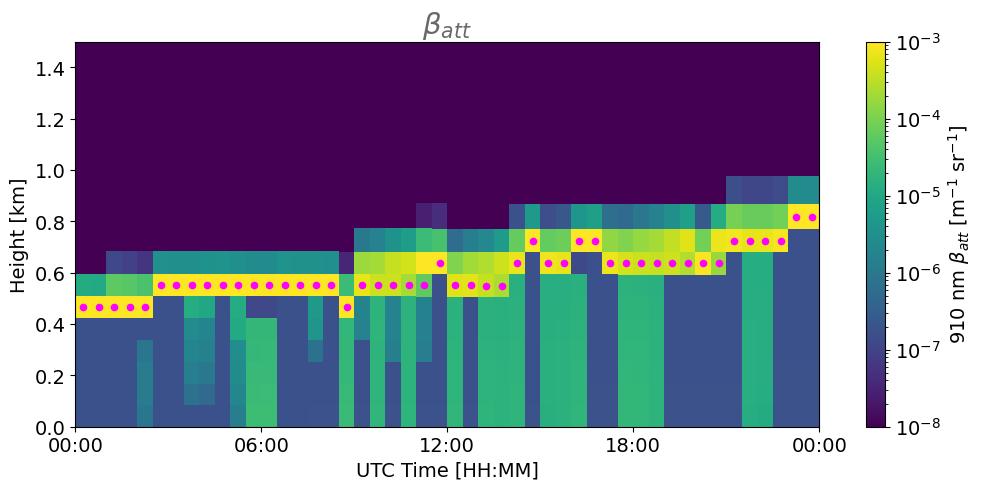

done


In [17]:
#--------------------------------------------------
# Plot figures for talks
#--------------------------------------------------
for day in unique_days[2:3]:
    time = outdict['time']
    dumid = np.where(days == day)
    dumid = np.squeeze(dumid)
    time = time[dumid]
    height = outdict['z'][dumid,:]
    ref = outdict['ref'][dumid,:,:]
    beta_att = outdict['beta_att'][dumid,:,:]
    level = outdict['level']
    detect_mask = outdict['detect_mask'][dumid,:,:]
    tot_pr = outdict['tot_pr'][dumid,:,:]
    temp = outdict['temp'][dumid,:]
    
    cbh,cbh_ids = calc_cbh(outdict['conv_frac_subcolumns_cl'][dumid,:,:],outdict['strat_frac_subcolumns_cl'][dumid,:,:],outdict['time'][dumid],outdict['z'][dumid,:])
    #------------------------
    # Individual Subcolumns
    #------------------------
    plot_figure_c(beta_att,time,height,level,detect_mask,cbh)
    #print(aaaa)
    

print('done')

In [170]:
def plot_figure_d(ref,beta_att,time,height,level,detect_mask,temp,tot_pr,cbh):

    plot_cbh_arg = True
    
    fig = plt.figure(figsize=(12,8))
    dfmt = mdates.DateFormatter('%H:%M')

    ymax=3

    ax1_ref = fig.add_subplot(3,3,1)
    ax2_ref = fig.add_subplot(3,3,2)
    ax3_ref = fig.add_subplot(3,3,3)


    ax1_beta_att = fig.add_subplot(3,3,4)
    ax2_beta_att = fig.add_subplot(3,3,5)
    ax3_beta_att = fig.add_subplot(3,3,6)
    
    ax1_pr = fig.add_subplot(3,3,7)
    ax2_pr = fig.add_subplot(3,3,8)
    ax3_pr = fig.add_subplot(3,3,9)

    ax_ref_list = [ax1_ref,ax2_ref,ax3_ref]
    ax_beta_att_list = [ax1_beta_att,ax2_beta_att,ax3_beta_att]
    ax_pr_list = [ax1_pr,ax2_pr,ax3_pr]
    Fontsize=13

    axlist = np.concatenate([ax_ref_list,ax_beta_att_list,ax_pr_list])

    for ax in axlist:
        ax.grid(which='both',ls='dotted',lw=1,c='grey')
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        
        dum_date = pd.to_datetime(time[0])
        dum_year = dum_date.year
        dum_month = dum_date.month
        dum_day = dum_date.day
        dum_hours = [0,6,12,18]
        dum_times = []
        for ii in range(4):
            dum_hour = dum_hours[ii]
            dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
        dum_times.append(dum_times[0]+datetime.timedelta(days=1))
        ax.set_xticks(dum_times)
        ax.set_ylim(0,ymax)
    
    #ax1_ref.set_title('Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    #ax1_beta_att.set_title('$\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    #ax1_pr.set_title('Precip. Rate',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')


    
    #---------------------------------
    # Reflectivity Plots
    #---------------------------------
    for ii in range(len(ax_ref_list)):
        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        ax = ax_ref_list[ii]
        
        cmap = matplotlib.cm.get_cmap("cividis").copy()
        cmap.set_under('w')
        cmap.set_bad('w')        
        
        #cmap = matplotlib.cm.get_cmap("nipy_spectral").copy()
        #cmap.set_bad('white')
        tmp_ref = ref[:,:,ii]
        tmp_ref_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_ref,\
                                vmin=-50.1,vmax=10.1,\
                                cmap=cmap)
        # colorbar
        #ref_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical',pad=0.01)
        #ref_cbar.ax.tick_params(labelsize=Fontsize)
        #ref_cbar.ax.set_ylabel('95 GHz Attenuated\n$Z_{e}$ [dBZ]',fontsize=Fontsize)   

        # hatch values below Ze_min
        var_array = tmp_ref
        mask_array = detect_mask[:,:,ii]
        hatch = '\\/...'
        ax.pcolor(x,\
                   y*1.e-3,\
                   np.ma.masked_where(mask_array == 0,np.ones_like(var_array)),\
                   hatch=hatch,\
                   alpha=0.)        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')

        # Plot CBH
        if plot_cbh_arg:
            tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=10,c='magenta',label='CBH')
            
    #---------------------------------
    # Attenuated Backscatter Plots
    #---------------------------------
    for ii in range(len(ax_beta_att_list)):
        ax = ax_beta_att_list[ii]
        tmp_beta_att = beta_att[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        #cmap = matplotlib.cm.get_cmap("viridis").copy()
        #cmap.set_under
        cmap = matplotlib.cm.get_cmap("viridis").copy()
        #from palettable.cmocean.sequential import Haline_20 as colormap
        #from palettable.cmocean.sequential import Thermal_20 as colormap
        #cmap = colormap.mpl_colormap
        #cmap.set_under('w')
        cmap.set_bad('grey')
        tmp_ceil_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                np.log10(tmp_beta_att),\
                                cmap=cmap,vmin=-8,vmax=-3)#,\
                                #norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
        # colorbar
        #beta_att_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical',pad=0.01)
        #beta_att_cbar.ax.tick_params(labelsize=Fontsize)
        #beta_att_cbar.ax.set_ylabel('910 nm $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        if plot_cbh_arg:
            tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=10,c='magenta',label='CBH')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')

    #---------------------------------
    # Precip. Rate Plots
    #---------------------------------
    for ii in range(len(ax_pr_list)):
        ax = ax_pr_list[ii]
        tmp_pr = tot_pr[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask

        #cmap = matplotlib.cm.get_cmap("twilight").copy()
        #cmap.set_under
        #from palettable.cmocean.sequential import Thermal_20 as colormap
        from palettable.cmocean.sequential import Ice_20_r as colormap
        cmap = colormap.mpl_colormap

        tmp_pr_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_pr,\
                                cmap=cmap,\
                                norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
        # colorbar
        #pr_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical',pad=0.01)
        #pr_cbar.ax.tick_params(labelsize=Fontsize)
        #pr_cbar.ax.set_ylabel('Precip. Rate [mm hr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        if plot_cbh_arg:
            tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=10,c='magenta',label='CBH')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')  
        
        
    #dumstr = dum_date.strftime('%m/%d/%Y')
    #plt.suptitle(dumstr,fontsize=Fontsize*2.)

    
    legend_elements = [Line2D([0], [0], label='0$^{\\circ}$C',lw=2,color='maroon',ls='dashed'),\
                      Line2D([0], [0], label='CBH',marker='o',c='white',markerfacecolor='magenta',markeredgecolor='magenta',markeredgewidth=0,markersize=5,alpha=1)]
    lgnd = ax2_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='lower center',framealpha=1,bbox_to_anchor=(0.5,-0.65),ncol=2)
    
    #ax2_ref.text(-0.25,0,'Subcolumns',transform=ax2_ref.transAxes,fontweight='bold',fontsize=Fontsize*2,color='dimgrey',ha='center',va='center',rotation=90)
    
    
    dumfac=0.75
    #------------------------
    # Reflectivity colorbar
    #------------------------
    cbar_ref_ax = fig.add_axes([0.91,0.67,0.01,0.21])
    # new ax with dimensions of the colorbar
    dum_ticks = [-50,-40,-30,-20,-20,-10,0,10]
    cbar_ref = fig.colorbar(tmp_ref_plot, cax=cbar_ref_ax,ticks=dum_ticks)       
    cbar_ref.ax.set_ylabel('95 GHz Attenuated\n$Z_{e}$ [dBZ]',fontsize=Fontsize*dumfac)
    cbar_ref.ax.tick_params(labelsize=Fontsize*dumfac)
    
    
    #------------------------
    # CEIL colorbar
    #------------------------
    cbar_ceil_ax = fig.add_axes([0.91,0.39,0.01,0.21])
    # new ax with dimensions of the colorbar
    dum_ticks = [-8,-7,-6,-5,-4,-3]
    cbar_ceil = fig.colorbar(tmp_ceil_plot, cax=cbar_ceil_ax,ticks=dum_ticks)       
    cbar_ceil.ax.set_ylabel('910 nm $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize*dumfac)
    cbar_ceil.ax.tick_params(labelsize=Fontsize*dumfac)   

    #------------------------
    # PR colorbar
    #------------------------
    cbar_pr_ax = fig.add_axes([0.91,0.11,0.01,0.21])
    # new ax with dimensions of the colorbar
    #dum_ticks = [-1.]
    cbar_pr = fig.colorbar(tmp_pr_plot, cax=cbar_pr_ax)#,ticks=dum_ticks)       
    cbar_pr.ax.set_ylabel('Precipitation Rate [mm hr$^{-1}$]',fontsize=Fontsize*dumfac)
    cbar_pr.ax.tick_params(labelsize=Fontsize*dumfac)      
    
    labs = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
    axlist = [ax1_ref,ax2_ref,ax3_ref,ax1_beta_att,ax2_beta_att,ax3_beta_att,ax1_pr,ax2_pr,ax3_pr]
    dumi=0
    for ax in axlist:
        ax.text(0.03,0.875,labs[dumi],fontsize=Fontsize*1.5,transform=ax.transAxes,ha='left',va='center',bbox=dict(facecolor='white', edgecolor='black',alpha=0.5))
        dumi+=1
    
    ax1_ref.text(0.5,1.1,'Subcolumn 1',c='dimgrey',fontweight='bold',transform=ax1_ref.transAxes,fontsize=Fontsize*1.5,ha='center',va='center')
    ax2_ref.text(0.5,1.1,'Subcolumn 2',c='dimgrey',fontweight='bold',transform=ax2_ref.transAxes,fontsize=Fontsize*1.5,ha='center',va='center')
    ax3_ref.text(0.5,1.1,'Subcolumn 3',c='dimgrey',fontweight='bold',transform=ax3_ref.transAxes,fontsize=Fontsize*1.5,ha='center',va='center')
    
    plt.subplots_adjust(hspace=0.35,wspace=0.25)
        
    fig_path = '/home/mwstanfo/figures/micre_paper/'
    outfile = 'fig_10.png'
    #outfile = 'fig_10.eps'
    plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')        
        
    #plt.show()
    plt.close()

In [171]:
#--------------------------------------------------
# Plot figures for talks
#--------------------------------------------------
for day in unique_days[2:3]:
    time = outdict['time']
    dumid = np.where(days == day)
    dumid = np.squeeze(dumid)
    time = time[dumid]
    height = outdict['z'][dumid,:]
    ref = outdict['ref'][dumid,:,:]
    beta_att = outdict['beta_att'][dumid,:,:]
    level = outdict['level']
    detect_mask = outdict['detect_mask'][dumid,:,:]
    tot_pr = outdict['tot_pr'][dumid,:,:]
    temp = outdict['temp'][dumid,:]
    
    cbh,cbh_ids = calc_cbh(outdict['conv_frac_subcolumns_cl'][dumid,:,:],outdict['strat_frac_subcolumns_cl'][dumid,:,:],outdict['time'][dumid],outdict['z'][dumid,:])
    #------------------------
    # 3 Subcolumns
    #------------------------
    plot_figure_d(ref,beta_att,time,height,level,detect_mask,temp,tot_pr,cbh)
    #print(aaaa)
    

/tmp/ipykernel_33087/3657723492.py:80: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  tmp_ref_plot = ax.pcolormesh(x,\
/tmp/ipykernel_33087/3657723492.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  tmp_ref_plot = ax.pcolormesh(x,\
/tmp/ipykernel_33087/3657723492.py:94: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(x,\
/tmp/ipykernel_33087/3657723492.py:131: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, b

In [ ]:
for day in unique_days[0:15]:
    time = outdict['time']
    dumid = np.where(days == day)
    dumid = np.squeeze(dumid)
    time = time[dumid]
    height = outdict['z'][dumid,:]
    ref = outdict['ref'][dumid,:,:]
    vel = outdict['vel'][dumid,:,:]
    beta_att = outdict['beta_att'][dumid,:,:]
    level = outdict['level']
    detect_mask = outdict['detect_mask'][dumid,:,:]
    tot_pr = outdict['tot_pr'][dumid,:,:]
    conv_pr = outdict['conv_pr'][dumid,:,:]
    strat_pr = outdict['strat_pr'][dumid,:,:]
    temp = outdict['temp'][dumid,:]
    
    cbh,cbh_ids = calc_cbh(outdict['conv_frac_subcolumns_cl'][dumid,:,:],outdict['strat_frac_subcolumns_cl'][dumid,:,:],outdict['time'][dumid],outdict['z'][dumid,:])
    #------------------------
    # Individual Subcolumns
    #------------------------
    plot_figure(ref,vel,beta_att,time,height,level,detect_mask,temp,tot_pr)
    
    #------------------------
    # Subcol Composites
    #------------------------
    # Max
    max_ref = np.nanmax(ref,axis=2)
    max_beta_att = np.nanmax(beta_att,axis=2) 
    max_tot_pr = np.nanmax(tot_pr,axis=2) 
    max_conv_pr = np.nanmax(conv_pr,axis=2) 
    max_strat_pr = np.nanmax(strat_pr,axis=2) 
    
    # Min
    min_vel = np.nanmin(vel,axis=2)
    
    # Mean
    mean_beta_att = np.nansum(beta_att,axis=2)/8.
    mean_vel = np.nansum(vel,axis=2)/8.
    mean_tot_pr = np.nansum(tot_pr,axis=2)/8.
    mean_conv_pr = np.nansum(conv_pr,axis=2)/8.
    mean_strat_pr = np.nansum(strat_pr,axis=2)/8.
    
    ze = ref.copy()
    dumid = np.where(~np.isnan(ref))
    ze[dumid] = 10.**(ref[dumid]/10.)
    nanid = np.where(np.isnan(ref))
    ze[nanid] = 0.
    
    mean_ze = np.sum(ze,axis=2)/8.
    dumid = np.where(mean_ze > 0.)
    mean_ref = mean_ze.copy()
    mean_ref[dumid] = 10.*(np.log10(mean_ze[dumid]))
    nanid = np.where(mean_ze == 0.)
    mean_ref[nanid] = np.nan
    
    plot_figure_2(max_ref,mean_ref,max_beta_att,mean_beta_att,min_vel,mean_vel,max_tot_pr,max_conv_pr,max_strat_pr,temp,time,height,level)    
    #print(aaa)

In [ ]:
def plot_figure(ref,vel,beta_att,time,height,level,detect_mask,temp,tot_pr):

    fig = plt.figure(figsize=(24,18))
    dfmt = mdates.DateFormatter('%H:%M')


    ax1_ref = fig.add_subplot(8,4,1)
    ax2_ref = fig.add_subplot(8,4,5)
    ax3_ref = fig.add_subplot(8,4,9)
    ax4_ref = fig.add_subplot(8,4,13)
    ax5_ref = fig.add_subplot(8,4,17)
    ax6_ref = fig.add_subplot(8,4,21)
    ax7_ref = fig.add_subplot(8,4,25)
    ax8_ref = fig.add_subplot(8,4,29)

    ax1_vel = fig.add_subplot(8,4,2)
    ax2_vel = fig.add_subplot(8,4,6)
    ax3_vel = fig.add_subplot(8,4,10)
    ax4_vel = fig.add_subplot(8,4,14)
    ax5_vel = fig.add_subplot(8,4,18)
    ax6_vel = fig.add_subplot(8,4,22)
    ax7_vel = fig.add_subplot(8,4,26)
    ax8_vel = fig.add_subplot(8,4,30)

    ax1_beta_att = fig.add_subplot(8,4,3)
    ax2_beta_att = fig.add_subplot(8,4,7)
    ax3_beta_att = fig.add_subplot(8,4,11)
    ax4_beta_att = fig.add_subplot(8,4,15)
    ax5_beta_att = fig.add_subplot(8,4,19)
    ax6_beta_att = fig.add_subplot(8,4,23)
    ax7_beta_att = fig.add_subplot(8,4,27)
    ax8_beta_att = fig.add_subplot(8,4,31)
    
    ax1_pr = fig.add_subplot(8,4,4)
    ax2_pr = fig.add_subplot(8,4,8)
    ax3_pr = fig.add_subplot(8,4,12)
    ax4_pr = fig.add_subplot(8,4,16)
    ax5_pr = fig.add_subplot(8,4,20)
    ax6_pr = fig.add_subplot(8,4,24)
    ax7_pr = fig.add_subplot(8,4,28)
    ax8_pr = fig.add_subplot(8,4,32)

    ax_ref_list = [ax1_ref,ax2_ref,ax3_ref,ax4_ref,ax5_ref,ax6_ref,ax7_ref,ax8_ref]
    ax_vel_list = [ax1_vel,ax2_vel,ax3_vel,ax4_vel,ax5_vel,ax6_vel,ax7_vel,ax8_vel]
    ax_beta_att_list = [ax1_beta_att,ax2_beta_att,ax3_beta_att,ax4_beta_att,ax5_beta_att,ax6_beta_att,ax7_beta_att,ax8_beta_att]
    ax_pr_list = [ax1_pr,ax2_pr,ax3_pr,ax4_pr,ax5_pr,ax6_pr,ax7_pr,ax8_pr]
    Fontsize=10

    axlist = np.concatenate([ax_ref_list,ax_vel_list,ax_beta_att_list,ax_pr_list])

    for ax in axlist:
        ax.grid(which='both',ls='dotted',lw=1,c='grey')
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        
        dum_date = pd.to_datetime(time[0])
        dum_year = dum_date.year
        dum_month = dum_date.month
        dum_day = dum_date.day
        dum_hours = [0,6,12,18]
        dum_times = []
        for ii in range(4):
            dum_hour = dum_hours[ii]
            dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
        dum_times.append(dum_times[0]+datetime.timedelta(days=1))
        ax.set_xticks(dum_times)
        ax.set_ylim(0,10)
    
    ax1_ref.set_title('Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_vel.set_title('$V_{Dop}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_beta_att.set_title('$\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_pr.set_title('Precip. Rate',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')


    ax4_ref.text(-0.25,0.5,'Subcolumns',transform=ax4_ref.transAxes,fontweight='bold',fontsize=Fontsize*2,color='dimgrey',ha='center',va='center',rotation=90)

    

    #---------------------------------
    # Reflectivity Plots
    #---------------------------------
    for ii in range(len(ax_ref_list)):
        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        ax = ax_ref_list[ii]
        cmap = matplotlib.cm.get_cmap("nipy_spectral").copy()
        cmap.set_bad('white')
        tmp_ref = ref[:,:,ii]
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_ref,\
                                vmin=-50.,vmax=20.,\
                                cmap=cmap)
        # colorbar
        ref_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        ref_cbar.ax.tick_params(labelsize=Fontsize)
        ref_cbar.ax.set_ylabel('95 GHz Attenuated\n$Z_{e}$ [dBZ]',fontsize=Fontsize)   

        # hatch values below Ze_min
        var_array = tmp_ref
        mask_array = detect_mask[:,:,ii]
        hatch = '\\/...'
        ax.pcolor(x,\
                   y*1.e-3,\
                   np.ma.masked_where(mask_array == 0,np.ones_like(var_array)),\
                   hatch=hatch,\
                   alpha=0.)        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    #---------------------------------
    # Doppler Velocity Plots
    #---------------------------------
    for ii in range(len(ax_vel_list)):
        ax = ax_vel_list[ii]
        tmp_vel = vel[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        cmap = matplotlib.cm.get_cmap("seismic").copy()
        cmap.set_extremes
    
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_vel,\
                                vmin=-2.,vmax=2.,\
                                cmap=cmap)
        # colorbar
        vel_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        vel_cbar.ax.tick_params(labelsize=Fontsize)
        vel_cbar.ax.set_ylabel('Stratiform $V_{Dop}$ [m s$^{-1}$]',fontsize=Fontsize)          
        
        # hatch values below Ze_min
        var_array = tmp_vel
        mask_array = detect_mask[:,:,ii]
        hatch = '\\/...'
        ax.pcolor(x,\
                   y*1.e-3,\
                   np.ma.masked_where(mask_array == 0,np.ones_like(var_array)),\
                   hatch=hatch,\
                   alpha=0.)           
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')        

    #---------------------------------
    # Attenuated Backscatter Plots
    #---------------------------------
    for ii in range(len(ax_beta_att_list)):
        ax = ax_beta_att_list[ii]
        tmp_beta_att = beta_att[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        cmap = matplotlib.cm.get_cmap("viridis").copy()
        cmap.set_under
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_beta_att,\
                                cmap=cmap,\
                                norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
        # colorbar
        beta_att_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        beta_att_cbar.ax.tick_params(labelsize=Fontsize)
        beta_att_cbar.ax.set_ylabel('910 nm $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')

    #---------------------------------
    # Precip. Rate Plots
    #---------------------------------
    for ii in range(len(ax_pr_list)):
        ax = ax_pr_list[ii]
        tmp_pr = tot_pr[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask

        cmap = matplotlib.cm.get_cmap("viridis").copy()
        cmap.set_under

        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_pr,\
                                cmap=cmap,\
                                norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
        # colorbar
        pr_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        pr_cbar.ax.tick_params(labelsize=Fontsize)
        pr_cbar.ax.set_ylabel('Precip. Rate [mm hr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        #tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
        #ax.legend(tmp_plot,fontsize=Fontsize,loc='upper right')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')  
        
        
    dumstr = dum_date.strftime('%m/%d/%Y')
    plt.suptitle(dumstr,fontsize=Fontsize*2.)

    
    legend_elements = [Line2D([0], [0], label='0$^{\\circ}$C',lw=2,color='maroon',ls='dashed'),\
                      Line2D([0], [0], label='CBH',marker='o',c='white',markerfacecolor='magenta',markeredgecolor='magenta',markeredgewidth=0,markersize=5,alpha=1)]
    lgnd = ax1_beta_att.legend(handles=legend_elements,fontsize=Fontsize*1.5,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.5),ncol=2)
    
    plt.subplots_adjust(top=0.925)
        
        
        
    plt.show()
    plt.close()

In [ ]:
def plot_figure_2(max_ref,mean_ref,max_beta_att,mean_beta_att,min_vel,mean_vel,max_tot_pr,nax_conv_pr,max_strat_pr,temp,time,height,level):
    Fontsize=12
    fig = plt.figure(figsize=(24,18))
    dfmt = mdates.DateFormatter('%H:%M')


    ax_max_ref = fig.add_subplot(531)
    ax_mean_ref = fig.add_subplot(534)
    ax_min_vel = fig.add_subplot(532)
    ax_mean_vel = fig.add_subplot(535)
    ax_max_beta_att = fig.add_subplot(533)
    ax_mean_beta_att = fig.add_subplot(536)
    ax_max_tot_pr = fig.add_subplot(537)
    ax_max_conv_pr = fig.add_subplot(538)
    ax_max_strat_pr = fig.add_subplot(539)
    ax_mean_tot_pr = fig.add_subplot(5,3,10)
    ax_mean_conv_pr = fig.add_subplot(5,3,11)
    ax_mean_strat_pr = fig.add_subplot(5,3,12)
    ax_temp = fig.add_subplot(5,3,13)
    
    axlist = [ax_max_ref,ax_mean_ref,ax_max_beta_att,ax_mean_beta_att,ax_min_vel,\
              ax_mean_vel,ax_max_tot_pr,ax_max_conv_pr,ax_max_strat_pr,ax_mean_tot_pr,ax_mean_conv_pr,ax_mean_strat_pr,ax_temp]
    
    for ax in axlist:
        ax.grid(which='both',ls='dotted',lw=1,c='grey')
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        
        dum_date = pd.to_datetime(time[0])
        dum_year = dum_date.year
        dum_month = dum_date.month
        dum_day = dum_date.day
        dum_hours = [0,6,12,18]
        dum_times = []
        for ii in range(4):
            dum_hour = dum_hours[ii]
            dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
        dum_times.append(dum_times[0]+datetime.timedelta(days=1))
        ax.set_xticks(dum_times)
        ax.set_ylim(0,10)
        
    ax_max_ref.set_title('Subcolumn Max Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_ref.set_title('Subcolumn Mean Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_min_vel.set_title('Subcolumn Min $V_{Dop}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_vel.set_title('Subcolumn Mean $V_{Dop}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_beta_att.set_title('Subcolumn Max $\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_beta_att.set_title('Subcolumn Mean $\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_tot_pr.set_title('Subcolumn Max Conv. + Stat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_conv_pr.set_title('Subcolumn Max Conv. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_strat_pr.set_title('Subcolumn Max Strat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_tot_pr.set_title('Subcolumn Max Conv. + Stat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_conv_pr.set_title('Subcolumn Mean Conv. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_strat_pr.set_title('Subcolumn Mean Strat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    
    
    time_2d = []
    for kk in range(len(height)):
        time_2d.append(time)
    time_2d = np.array(time_2d)
    p = level
    x = time
    y = height
    x,p = np.meshgrid(x,p)
    x = x.T
    mask_array = detect_mask     
    
    #---------------------------------
    # Max Reflectivity Plot
    #---------------------------------
    cmap = plt.cm.nipy_spectral
    tmp_plot = ax_max_ref.pcolormesh(x,\
                            y*1.e-3,\
                            max_ref,\
                            vmin=-50.,vmax=20.,\
                            cmap=cmap)
    # colorbar
    ref_cbar = plt.colorbar(tmp_plot,ax=ax_max_ref,orientation='vertical')
    ref_cbar.ax.tick_params(labelsize=Fontsize)
    ref_cbar.ax.set_ylabel('Subcol. Max Reflectivity [dBZ]',fontsize=Fontsize)     
    #---------------------------------
    # Mean Reflectivity Plot
    #---------------------------------
    cmap = plt.cm.nipy_spectral
    tmp_plot = ax_mean_ref.pcolormesh(x,\
                            y*1.e-3,\
                            mean_ref,\
                            vmin=-50.,vmax=20.,\
                            cmap=cmap)
    # colorbar
    ref_cbar = plt.colorbar(tmp_plot,ax=ax_mean_ref,orientation='vertical')
    ref_cbar.ax.tick_params(labelsize=Fontsize)
    ref_cbar.ax.set_ylabel('Subcol. Mean Reflectivity [dBZ]',fontsize=Fontsize)     
    
    #---------------------------------
    # Max Beta Att Plot
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_beta_att.pcolormesh(x,\
                            y*1.e-3,\
                            max_beta_att,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
    # colorbar
    beta_att_cbar = plt.colorbar(tmp_plot,ax=ax_max_beta_att,orientation='vertical')
    beta_att_cbar.ax.tick_params(labelsize=Fontsize)
    beta_att_cbar.ax.set_ylabel('Subcol. Max $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)      
    
    #---------------------------------
    # Mean Beta Att Plot
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_beta_att.pcolormesh(x,\
                            y*1.e-3,\
                            mean_beta_att,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
    # colorbar
    beta_att_cbar = plt.colorbar(tmp_plot,ax=ax_mean_beta_att,orientation='vertical')
    beta_att_cbar.ax.tick_params(labelsize=Fontsize)
    beta_att_cbar.ax.set_ylabel('Subcol. Mean $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)       
    #---------------------------------
    # Min VDop Plot
    #---------------------------------
    cmap = plt.cm.seismic
    cmap.set_extremes
    tmp_plot = ax_min_vel.pcolormesh(x,\
                            y*1.e-3,\
                            min_vel,\
                            cmap=cmap,\
                            vmin=-2,vmax=2)
    # colorbar
    vel_cbar = plt.colorbar(tmp_plot,ax=ax_min_vel,orientation='vertical')
    vel_cbar.ax.tick_params(labelsize=Fontsize)
    vel_cbar.ax.set_ylabel('Subcol. Min $V_{Dop}$ [m s$^{-1}$]',fontsize=Fontsize)      

    
    #---------------------------------
    # Mean VDop Att Plot
    #---------------------------------
    cmap = plt.cm.seismic
    cmap.set_extremes
    tmp_plot = ax_mean_vel.pcolormesh(x,\
                            y*1.e-3,\
                            mean_vel,\
                            cmap=cmap,\
                            vmin=-2,vmax=2)
    # colorbar
    vel_cbar = plt.colorbar(tmp_plot,ax=ax_mean_vel,orientation='vertical')
    vel_cbar.ax.tick_params(labelsize=Fontsize)
    vel_cbar.ax.set_ylabel('Subcol. Mean $V_{Dop}$ [m s$^{-1}$]',fontsize=Fontsize)     

    #---------------------------------
    # Subcolumn Max Total Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_tot_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_tot_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    tot_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_tot_pr,orientation='vertical')
    tot_pr_cbar.ax.tick_params(labelsize=Fontsize)
    tot_pr_cbar.ax.set_ylabel('Subcol. Max Conv + Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)     

    
    #---------------------------------
    # Subcolumn Max Convective Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_conv_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_conv_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    conv_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_conv_pr,orientation='vertical')
    conv_pr_cbar.ax.tick_params(labelsize=Fontsize)
    conv_pr_cbar.ax.set_ylabel('Subcol. Max Conv\nPR [mm hr$^{-1}$]',fontsize=Fontsize)        
    
    #---------------------------------
    # Subcolumn Max Stratiform Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_strat_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_strat_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    strat_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_strat_pr,orientation='vertical')
    strat_pr_cbar.ax.tick_params(labelsize=Fontsize)
    strat_pr_cbar.ax.set_ylabel('Subcol. Max Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)       
    
    #---------------------------------
    # Subcolumn Mean Total Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_tot_pr.pcolormesh(x,\
                            y*1.e-3,\
                            mean_tot_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    tot_pr_cbar = plt.colorbar(tmp_plot,ax=ax_mean_tot_pr,orientation='vertical')
    tot_pr_cbar.ax.tick_params(labelsize=Fontsize)
    tot_pr_cbar.ax.set_ylabel('Subcol. Mean Conv + Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)     

    
    #---------------------------------
    # Subcolumn Mean Convective Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_conv_pr.pcolormesh(x,\
                            y*1.e-3,\
                            mean_conv_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    conv_pr_cbar = plt.colorbar(tmp_plot,ax=ax_mean_conv_pr,orientation='vertical')
    conv_pr_cbar.ax.tick_params(labelsize=Fontsize)
    conv_pr_cbar.ax.set_ylabel('Subcol. Mean Conv\nPR [mm hr$^{-1}$]',fontsize=Fontsize)        
    
    #---------------------------------
    # Subcolumn Mean Stratiform Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_strat_pr.pcolormesh(x,\
                            y*1.e-3,\
                            mean_strat_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    strat_pr_cbar = plt.colorbar(tmp_plot,ax=ax_mean_strat_pr,orientation='vertical')
    strat_pr_cbar.ax.tick_params(labelsize=Fontsize)
    strat_pr_cbar.ax.set_ylabel('Subcol. Mean Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)
    
    #---------------------------------
    # Temperature
    #---------------------------------
    cmap = plt.cm.RdYlBu_r
    tmp_plot = ax_temp.pcolormesh(x,\
                            y*1.e-3,\
                            temp-273.15,\
                            cmap=cmap,\
                            vmin=-60,vmax=20)
    
    # colorbar
    temp_cbar = plt.colorbar(tmp_plot,ax=ax_temp,orientation='vertical')
    temp_cbar.ax.tick_params(labelsize=Fontsize)
    temp_cbar.ax.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)  
    
    ax_temp.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_tot_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_beta_att.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_mean_beta_att.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_ref.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_mean_ref.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_min_vel.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_mean_vel.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_conv_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_strat_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    
    legend_elements = [Line2D([0], [0], label='0$^{\\circ}$C',lw=2,color='maroon',ls='dashed')]
    lgnd = ax_temp.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_tot_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_beta_att.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_mean_beta_att.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_ref.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_mean_ref.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_min_vel.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_mean_vel.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_conv_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_strat_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    
    dumstr = dum_date.strftime('%m/%d/%Y')
    plt.suptitle(dumstr,fontsize=Fontsize*2.)
    
    plt.subplots_adjust(top=0.9,hspace=0.5)
        
        
        
    plt.show()
    plt.close()